In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mayavi import mlab
import matplotlib.cm as cm
import sys

In [2]:
def calculate_point_error(true_csd, est_csd):
    """
    Calculates normalized error of reconstruction at every point of
    estimation space separetly.

    Parameters
    ----------
    true_csd: numpy array
        Values of true csd at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.

    Returns
    -------
    point_error: numpy array
        Normalized error of reconstruction calculated separetly at every
        point of estimation space.
    """
    true_csd_r = true_csd.reshape(true_csd.size, 1)
    est_csd_r = est_csd.reshape(est_csd.size, 1)
    epsilon = np.linalg.norm(true_csd_r)/np.max(abs(true_csd_r))
    err_r = abs(est_csd_r/(np.linalg.norm(est_csd_r)) -
                true_csd_r/(np.linalg.norm(true_csd_r)))
    err_r *= epsilon
    point_error = err_r.reshape(true_csd.shape)
    return point_error

In [3]:
def sigmoid_error(error):
    '''
    Calculates sigmoidal mean across errors of reconstruction for many
    different sources - used for error maps.

    Parameters
    ----------
    error: numpy array
    Normalized point error of reconstruction.

    Returns
    -------
    error_mean: numpy array
    Sigmoidal mean error of reconstruction.
    error_mean -> 1    - very poor reconstruction
    error_mean -> 0    - perfect reconstruction
    '''
    sig_error = 2*(1./(1 + np.exp((-error))) - 1/2.)
    return sig_error

In [4]:
def calculate_rms(true_csd, est_csd):
    """
    Calculates normalized error of reconstruction.
    Parameters
    ----------
    true_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    rms: float
        Normalized error of reconstruction.
    """
    rms = np.linalg.norm((true_csd - est_csd))/(np.linalg.norm(true_csd))
    return rms

In [5]:
def calculate_rdm(true_csd, est_csd):
    """
    Calculates relative difference measure between reconstructed source and
    ground truth.
    Parameters
    ----------
    true_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    rdm: float
        Relative difference measure.
    """
    epsilon = np.finfo(np.float64).eps
    rdm = np.linalg.norm(est_csd/(np.linalg.norm(est_csd) + epsilon) -
                         true_csd/(np.linalg.norm(true_csd) + epsilon))
    return rdm

In [6]:
def calculate_mag(true_csd, est_csd):
    """
    Calculates magnitude ratio between reconstructed source and ground
    truth.
    Parameters
    ----------
    test_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    mag: float
        Magnitude ratio.
    """
    epsilon = np.finfo(np.float64).eps
    mag = np.linalg.norm(est_csd/(true_csd + epsilon))
    return mag

In [7]:
def make_plot(values, val_type, X, Y, Z, path, idx=15, fig_title=None):
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.set_title(fig_title)
    if val_type == 'csd':
        cmap = cm.bwr
        t_max = np.max(np.abs(values))
        t_min = -t_max
    else:
        cmap = cm.Greys
        t_max = np.max(np.abs(values))#1
        t_min = 0
    levels = np.linspace(t_min, t_max, 65)
    ax.set_aspect('equal')
    im = ax.contourf(X[idx, :, :], Z[idx, :, :], values[:, idx, :], levels=levels, cmap=cmap, alpha=1)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_xticks([X.min(), 0, X.max()])
    ax.set_yticks([Z.min(), 0, Z.max()])
    ticks = np.linspace(t_min, t_max, 3, endpoint=True)
    plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)
    plt.savefig(path + '/' + str(fig_title) +'.png', dpi=300)
    return

In [8]:
# Generate estimation points
r = 0.09
X, Y, Z = np.meshgrid(np.linspace(-r, r, 30),
                      np.linspace(-r, r, 30),
                      np.linspace(-r, r, 30))
IDX = X**2 + Y**2 + Z**2 <=r**2
EST_X = X[IDX]
EST_Y = Y[IDX]
EST_Z = Z[IDX]

In [9]:
filename = '../whole_sphere_parallel_1000_deg_1.npz'
#filename = '../four_spheres_parallel_1000_deg_1_rp_0.npz'
with np.load(filename) as fh:
    true_csd = fh['TRUE_CSD']
    est_csd = fh['EST_CSD']

In [10]:
filename_r = '../whole_sphere_parallel_1000_deg_1_rp_0054.npz'
#filename_r = '../four_spheres_1000_deg_1_rp_001.npz'
with np.load(filename_r) as frh:
    est_csd_r = frh['EST_CSD']

In [11]:
error = np.array([calculate_point_error(t_csd, e_csd) for t_csd, e_csd in zip(true_csd, est_csd)])
error_r = np.array([calculate_point_error(t_csd, e_csd_r) for t_csd, e_csd_r in zip(true_csd, est_csd_r)])

In [12]:
error_mean = np.mean(error, axis=0)
error_r_mean = np.mean(error_r, axis=0)

In [13]:
src_nr = 0
layer = 15
path = sys.path[0]

In [14]:
def generate_figure(X, Y, Z, values, values_type, IDX, layer, title, save_path=sys.path[0]):
    VALUES = np.zeros(X.shape)  
    for v, i, j, k in zip(values, *np.where(IDX)):  # place values in regular grid
        VALUES[i, j, k] = v
    make_plot(VALUES, values_type, X, Y, Z, save_path, idx=layer, fig_title=title)

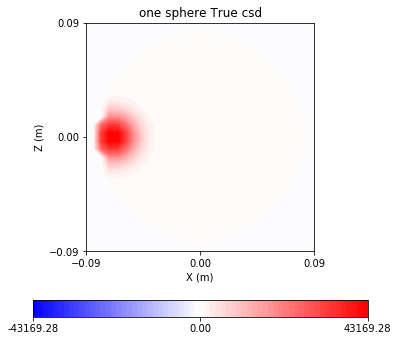

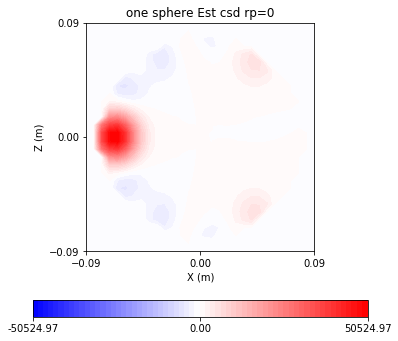

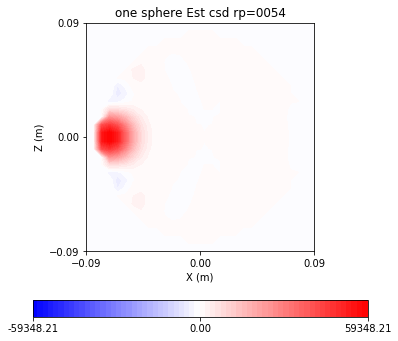

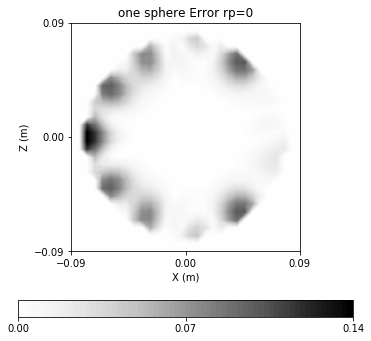

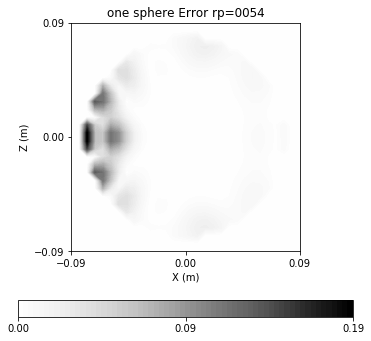

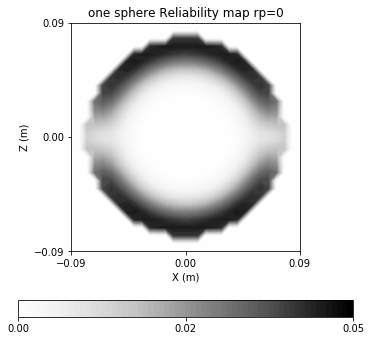

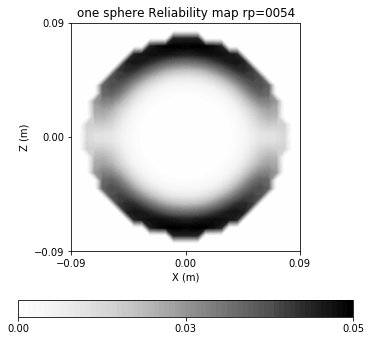

In [15]:
sphere = 'one sphere'
#sphere = 'four spheres'
generate_figure(X, Y, Z, true_csd[src_nr], 'csd', IDX, layer, str(sphere)+' True csd')
generate_figure(X, Y, Z, est_csd[src_nr], 'csd', IDX, layer, str(sphere)+' Est csd rp=0')
generate_figure(X, Y, Z, est_csd_r[src_nr], 'csd', IDX, layer, str(sphere)+' Est csd rp=0054')
generate_figure(X, Y, Z, error[src_nr], 'err', IDX, layer, str(sphere)+' Error rp=0')
generate_figure(X, Y, Z, error_r[src_nr], 'err', IDX, layer, str(sphere)+' Error rp=0054')
generate_figure(X, Y, Z, error_mean, 'err', IDX, layer, str(sphere)+' Reliability map rp=0')
generate_figure(X, Y, Z, error_r_mean, 'err', IDX, layer, str(sphere)+' Reliability map rp=0054')

In [38]:
diff_r = true_csd[src_nr]-est_csd_r[src_nr]

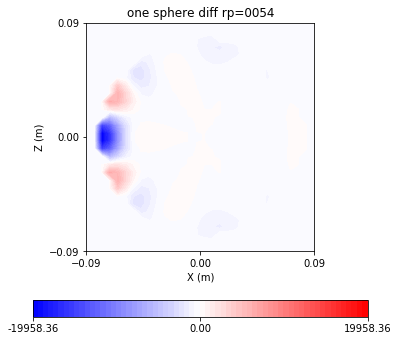

In [39]:
generate_figure(X, Y, Z, diff_r, 'csd', IDX, layer, str(sphere)+' diff rp=0054')

In [16]:
rms = calculate_rms(true_csd[src_nr], est_csd[src_nr])

In [17]:
rdm = calculate_rdm(true_csd[src_nr], est_csd[src_nr])

In [18]:
mag = calculate_mag(true_csd[src_nr], est_csd[src_nr])

In [19]:
def point_errors_Ch(true_csd, est_csd):
    nrm_est = est_csd.reshape(est_csd.size, 1) / np.max(np.abs(est_csd))
    nrm_csd = true_csd.reshape(true_csd.size, 1) / np.max(np.abs(true_csd))
    err = abs(nrm_csd - nrm_est).reshape(true_csd.shape)
    return err

In [20]:
def calculate_rdmp(true_csd, est_csd):
    rdm = abs(est_csd.reshape(est_csd.size, 1)/(np.linalg.norm(est_csd.reshape(est_csd.size, 1))) -
              true_csd.reshape(true_csd.size, 1)/(np.linalg.norm(true_csd.reshape(true_csd.size, 1))))
    rdm *= np.linalg.norm(true_csd.reshape(true_csd.size, 1))/np.max(abs(true_csd.reshape(true_csd.size, 1)))
    return rdm.reshape(true_csd.shape)

In [21]:
def calculate_magp(true_csd, est_csd):
    epsilon = np.max(abs(true_csd.reshape(true_csd.size, 1)))
    mag = abs(est_csd.reshape(est_csd.size, 1))/(abs(true_csd.reshape(true_csd.size, 1)) + epsilon)
    return mag.reshape(true_csd.shape)

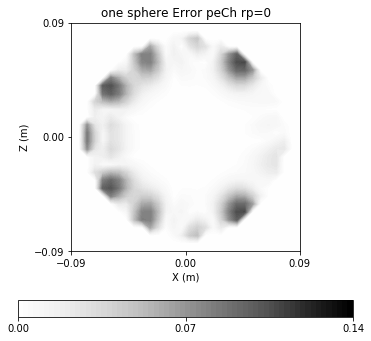

In [22]:
peCh = point_errors_Ch(true_csd[src_nr], est_csd[src_nr])
generate_figure(X, Y, Z, peCh, 'err', IDX, layer, str(sphere)+' Error peCh rp=0')

In [26]:
peCh.max()

0.1416168888212575

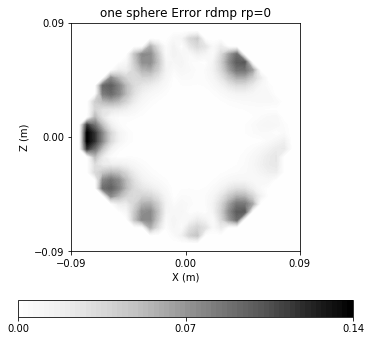

In [27]:
rdmp = calculate_rdmp(true_csd[src_nr], est_csd[src_nr])
generate_figure(X, Y, Z, rdmp, 'err', IDX, layer, str(sphere)+' Error rdmp rp=0')

In [28]:
rdmp.max()

0.13930765275059082

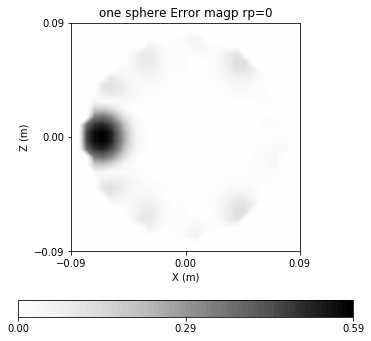

In [29]:
magp = calculate_magp(true_csd[src_nr], est_csd[src_nr])
generate_figure(X, Y, Z, magp, 'err', IDX, layer, str(sphere)+' Error magp rp=0')

In [30]:
def calculate_point_error_wrong(true_csd, est_csd):
    """
    Calculates normalized error of reconstruction at every point of
    estimation space separetly.
    Parameters
    ----------
    true_csd: numpy array
        Values of true csd at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    point_error: numpy array
        Normalized error of reconstruction calculated separetly at every
        point of estimation space.
    """
    epsilon = np.finfo(np.float64).eps
    point_error = np.linalg.norm(true_csd.reshape(true_csd.size, 1) -
                                 est_csd.reshape(est_csd.size, 1), axis=1)
    point_error /= np.linalg.norm(true_csd.reshape(true_csd.size, 1),
                                  axis=1) + \
                                  epsilon*np.max(np.linalg.norm(true_csd.reshape(true_csd.size, 1), axis=1))
    return point_error

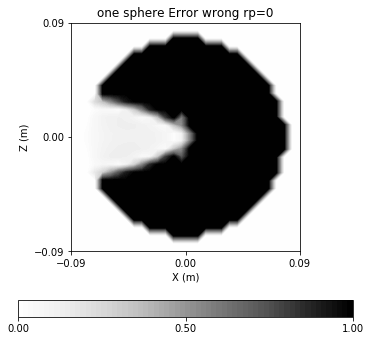

In [36]:
wrong_err = calculate_point_error_wrong(true_csd[src_nr], est_csd[src_nr])
wrong_err_sig = sigmoid_error(wrong_err)
generate_figure(X, Y, Z, wrong_err_sig, 'err', IDX, layer, str(sphere)+' Error wrong rp=0')